In [29]:
import networkx as nx
import statistics
import scipy.stats
import scipy.spatial.distance
import matplotlib.pyplot as plt
import os
import sys

In [30]:



# Given a NeworkX graph, determines the degree of each node 
# graph: NetworkX graph
# returns a dictionary of node:degree pairs
def get_degree(graph):
   deg_dict = {node: graph.degree(node) for node in graph.nodes()} 
   return deg_dict


# Given a NeworkX graph, determines the clustering coefficientof each node 
# graph: NetworkX graph
# Returns a dictionary of node:clustering coefficient pairs
def get_cc(graph):
    cc_dict  ={node: nx.clustering(graph,node) for node in graph.nodes()}
    return cc_dict

# Given a NeworkX graph, determines the average number of two hop neighbors (thn)
# of each node 
# graph: NetworkX graph
# Returns a dictionary of node:thn pairs
def get_thn(graph):
    thn_dict = {}
    for node in graph.nodes():
        neighbors = nx.all_neighbors(graph, node)
        mean_neighbor_degree = statistics.mean([nx.degree(graph, neighbor) for neighbor in neighbors])
        thn_dict[node] = mean_neighbor_degree
    return thn_dict

# Given a NeworkX graph, determines the average clustering coefficient of each 
# node's neighbors (ncc)
# graph: NetworkX graph
# Returns a dictionary of node:ncc pairs
def get_ncc(graph):
    ncc_dict = {}
    for node in graph.nodes():
        neighbors = nx.all_neighbors(graph, node)
        ncc = statistics.mean([nx.clustering(graph, neighbor) for neighbor in neighbors])
        ncc_dict[node] = ncc
    return ncc_dict

# Given a NeworkX graph, determines the number of edges in each node's egonet
# of each node (ee)
# graph: NetworkX graph
# Returns a dictionary of node:ncc pairs
def get_ee(graph):
    ee_dict = {node: len(nx.ego_graph(graph, node).edges()) for node in graph.nodes()}
    return ee_dict

# Given a NeworkX graph, determines the number of outgoing edges extending from the 
# egonet of each node (eeo)
# graph: NetworkX graph
# Returns a dictionary of node:eeo pairs
def get_eeo(graph):
    eeo_dict = {}
    for node in graph.nodes():
        src_nodes = set(nx.all_neighbors(graph, node))
        src_nodes.add(node)
        num_out_edges = 0
        for src_node in src_nodes:
            dst_nodes = set(nx.all_neighbors(graph,src_node))
            new_out_edges = dst_nodes.difference(src_nodes)
            num_out_edges += len(new_out_edges)
        eeo_dict[node] = num_out_edges
    return eeo_dict

# Given a NeworkX graph, determines the number of neighbors of each node's egonet (egn)
# graph: NetworkX graph
# Returns a dictionary of node:egn pairs
def get_egn(graph):
    egn_dict = {}
    for node in graph.nodes():
        egonet = set(nx.all_neighbors(graph, node))
        egonet.add(node)
        egonet_neighbors = set()
        for ego_node in egonet:
            neighbors = set(nx.all_neighbors(graph,ego_node))
            egonet_neighbors = egonet_neighbors.union(neighbors)
        filtered_neighbors = egonet_neighbors.difference(egonet)
        egn_dict[node] = len(filtered_neighbors)

    return egn_dict

# Given a NeworkX graph, performs the feature aggregation described in the NetSimile 
# algorithm
# graph: NetworkX graph
# Returns a feature signature vector for the graph
def aggregate_features(graph):
    f1 = get_degree(graph)
    f2 = get_cc(graph)
    f3 = get_thn(graph)   
    f4 = get_ncc(graph)   
    f5 = get_ee(graph)   
    f6 = get_eeo(graph)   
    f7 = get_egn(graph)   
    feature_matrix = [[f1[u], f2[u], f3[u], f4[u], f5[u], f6[u], f7[u]] for u in graph.nodes()]
    signature = []
    for feature in range(0, len(feature_matrix[0])):
        mean = statistics.mean([feature_matrix[row][feature] for row in range(0,len(feature_matrix))])
        median = statistics.median([feature_matrix[row][feature] for row in range(0,len(feature_matrix))])
        stdev = statistics.stdev([feature_matrix[row][feature] for row in range(0,len(feature_matrix))])
        skewness = scipy.stats.skew([feature_matrix[row][feature] for row in range(0,len(feature_matrix))])
        kurtosis = scipy.stats.kurtosis([feature_matrix[row][feature] for row in range(0,len(feature_matrix))])
        feature_set = [mean,median,stdev,skewness,kurtosis]
        signature += feature_set
    return signature

# Given a time series of distances between adjacent veectors, returns the calculated
# threshold for identifying out of family measurements,
# distances: a list of distances between adjacent vectors
# Returns a tuple of lower and upper thresholds
def get_thresholds(distances):
    moving_range = 0
    for i in range(0, len(distances) - 1):
        moving_range += abs(distances[i] - distances[i+1])
    moving_range_avg = moving_range / (len(distances) - 1)
    median = statistics.median(distances)
    return (median - (3 * moving_range_avg), median + (3 * moving_range_avg))

# Given the relative path to a directory of edgelists, reads each edgelist one-
# by-one, and builds a NetworkX graph.  
# input_directory: relative path to directory of graph files
# Returns a list of graphs sorted by name index
def read_files(input_directory):
    graphs = {}
    sorted_graphs = []
    listing = os.listdir(input_directory)
    file_count = len(listing)
    file_index = 1
    for file in listing:
        path = input_directory + file
        id = int(file.split('_')[0])
        graphs[id] = read_graph(path)
        show_progress('Reading graphs: ',file_index, file_count)
        file_index += 1
    print('')
    sorted_keys = sorted(graphs)
    for key in sorted_keys:
        sorted_graphs.append(graphs[key])
    return sorted_graphs

# Given a file path, reads the file and returns a NetworkX graph 
# infile: full path to an edgelist
# Note: This method ignores the first line as the node/edge count
# is not used for NetworkX
# Returns a NetworkX graph
def read_graph(infile):
    file = open(infile, 'r')
    
    # throw away first line
    file.readline()

    graph=nx.parse_edgelist(file, nodetype=int)
    return graph

# Given a time series of distances between adjacent signature vectors,
# a threshold, writes a graph image to the specified imagefile.
# distances: a list of distances between adjacent vectors
# UCL: upper threshold for determining out of family values
# imagefile: output file
def draw_plot(distances, UCL, imagefile):
    fig = plt.figure()
    plt.plot(distances, '-+')
    plt.axhline(y=UCL,c='g')
    plt.title('Similarity (Canberra Distance) vs Time for P2P-Gnutella Data')
    plt.xlabel('Time')
    plt.ylabel("Similarity")
    #plt.show()
    plt.savefig(imagefile)

# Given a time series of distances between adjacent signature vectors,
# and an output data file, writes a summary to the datafile.
# distances: a list of distances between adjacent vectors
# datafile: output data file
def write_data(distances, datafile):
    file = open(datafile,'w')
    for index, distance in enumerate(distances):
        file.write('%s %s\n' % (index, distance))
    file.close

# Given the current progress of an incrementer, prints a percentage
# progress to stdout.
# state: string representing current operation
# index: current index of incrementer
# count: end index of incrementer
def show_progress(state,index, count):
    percentage = float(index) / float(count) * 100
    sys.stdout.write('\r%s %d%% Complete' % (state, percentage))
    sys.stdout.flush()

In [4]:
%reload_ext autoreload
%autoreload
%matplotlib inline
from myHelper import timing
from myHelper import GraphSignalHelper
import numpy as np
from myHelper import db_helper

DB_dir ='./mitbih-database/'
p_id = '106'
r_detect = 'two_aver'
    
data_df = db_helper.read_heartbeat_database(DB_dir, p_id, nRowsRead=None)
annotations_df = db_helper.read_annotation_database(DB_dir, p_id)

# downsampling the signal
downstep = 8
(downsp_data_df, downsp_annotations_df) = GraphSignalHelper.downsample(data_df,
                                                               annotations_df,
                                                               downstep)
# split the the signal into heartbeat using the R-peak detection
heart_beats, hbs_annotations = GraphSignalHelper.heartbeat_spliting(downsp_data_df, 
                                                    downsp_annotations_df,
                                                    R_detector=r_detect,
                                                    fs = (360 / downstep))
# labeling heartbeats by looking at their annotations into 
# (-1) or (1) for Anomalous or Normal
hb_labels = GraphSignalHelper.anomaly_labels(hbs_annotations)


graph_stream, graph_stream_labels = GraphSignalHelper.generate_graph_stream(heart_beats, 
                                                                            hb_labels)
len(graph_stream)
# 2081

2081

In [5]:
# sorted_graphs = []
graph_stream[0]

In [10]:
graphs = []
signatures = []
distances = []
anomalies = []

sorted_graphs = []
sorted_keys = sorted(graph_stream)
for key in sorted_keys:
    sorted_graphs.append(graph_stream[key])
    
graphs = sorted_graphs

for index, graph in enumerate(graphs):
    signature = aggregate_features(graph)
    signatures.append(signature)
    show_progress('Aggregating features: ',index + 1, len(graphs))

Aggregating features:  100% Complete

In [11]:
len(signatures)

2081

In [12]:
for i in range(0, len(signatures) - 1):
    distance = abs(scipy.spatial.distance.canberra(signatures[i], signatures[i+1]))
    distances.append(distance)

In [13]:
len(distances)

2080

<ipython-input-20-9bedc2228427>:1: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  hist, bins = np.histogram(distances, bins=200, normed=True)


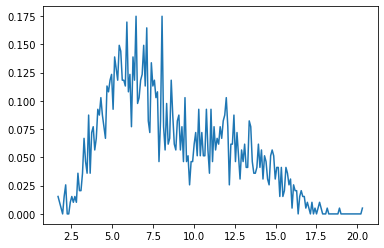

In [20]:
hist, bins = np.histogram(distances, bins=200, normed=True)
bin_centers = (bins[1:]+bins[:-1])*0.5
plt.plot(bin_centers, hist)

In [21]:
LCL, UCL = get_thresholds(distances)

# Threshold maybe have to be modified
I am not sure

In [22]:
for i in range(0, len(distances) - 1):
    if distances[i] >= UCL and distances[i+1] >= UCL:
        anomalies.append(i+1)


In [28]:
graph_stream_labels[98:102]

array([ 1,  1,  1, -1])

In [25]:
[i for i in anomalies ]

[110,
 148,
 151,
 203,
 889,
 945,
 1041,
 1120,
 1135,
 1214,
 1273,
 1300,
 1301,
 1416,
 1460,
 1467,
 1774,
 1810,
 1871,
 1914,
 1928,
 1971,
 2006,
 2021]

In [45]:
sys.stdout.write('\nAnomalies based on threshold of %s:\n' % UCL)


Anomalies based on threshold of 15.066965175807786:


In [46]:
sys.stdout.write('\nAnomalies based on threshold of %s:\n' % UCL)
for anomaly in anomalies:
    print(anomaly)
if len(anomalies) == 0:
    print('No anomalies detected.')


Anomalies based on threshold of 15.066965175807786:
110
148
151
203
889
945
1041
1120
1135
1214
1273
1300
1301
1416
1460
1467
1774
1810
1871
1914
1928
1971
2006
2021


In [ ]:
graphs = []
signatures = []
distances = []
anomalies = []

graphs = read_files(input_directory)

for index, graph in enumerate(graphs):
    signature = aggregate_features(graph)
    signatures.append(signature)
    show_progress('Aggregating features: ',index + 1, len(graphs))

for i in range(0, len(signatures) - 1):
    distance = abs(scipy.spatial.distance.canberra(signatures[i], signatures[i+1]))
    distances.append(distance)
LCL, UCL = get_thresholds(distances)

for i in range(0, len(distances) - 1):
    if distances[i] >= UCL and distances[i+1] >= UCL:
        anomalies.append(i+1)

sys.stdout.write('\nAnomalies based on threshold of %s:\n' % UCL)
for anomaly in anomalies:
    print anomaly
if len(anomalies) == 0:
    print 'No anomalies detected.'

write_data(distances, data_outfile)

draw_plot(distances, UCL, image_outfile)